In [1]:
%pylab inline
from scipy.integrate import odeint


Populating the interactive namespace from numpy and matplotlib


# Variables y constantes
Datos llantas

In [2]:
rll=0.175 # Radio geometrico de las llantas traseras [m]
refc=0.98*rll # Radio efectivo llantas traseras [m]
rin=0.0631  #Radio interno de neum'atico [m]

Datos Transmision 

In [3]:
dp=20 #Dientes del piñon
dpl=64 #Dientes del plato(eje)
ng=dpl/dp #Relacion de Transmision 
etaf=0.95 #Eficiencia de transmision 


Datos eje llantas

In [4]:
reje=0.02  #Radio eje de las llantas [m]
meje=3.832 #Masa del eje (kg)

Datos Kart general

In [5]:
masa=152.0 #Masa kart [kg]
g=9.81 #Gravedad [m/s]
w=masa*g #Peso del kart [N]


Datos Fuerzas de la formula de aceleracion 

In [6]:
rho=1.1955 # densidad del aira [kg/m^3]
dll=0.975 #Distancia entre llantas delanteras (m)
alj=0.88 #Altura con el piloto sentado en el kart (estatura 1.68 m )[m]
af=(dll*alj)/2 #Area frontal kart [m^2]
#Se asume el area del kart como un triangulo
cd=0.89 #Coeficiente de Arrastre del Kart
vw=0.0 #Velocidad del viento[m/s]
theta=0.0 #angulo carretera


Inercias

In [7]:
ii=5.2E-3 #Inercia Motor de Combustión 

mllt=1.43 #Masa de las llantas traseras [kg]
mlld= 1.20 # Masa llantas delanteras [kg]
rlld=0.129 #Radio de las llantas delanteras [m]
rind=0.0631 #Radio rin llantas delanteras [m]
refd=0.98*rlld #Radio efectivo llanta delantera
mbt=0.7*mllt # La masa total que pesa la parte "banda" de la llanta trasera [kg]
mdt=0.3*mllt # La masa total que pesa la parte "disco" de la llanta trasera [kg]
mbd=0.7*mlld # La masa total que pesa la parte "banda" de la llanta delantera [kg]
mdd=0.3*mlld # La masa total que pesa la parte "disco" de la llanta delantera[kg]
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525#Radio piñon [m]
rpla=0.04096 #[m]
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

Fuerzas Aceleración 

In [8]:
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera [m]
l=1.0063 # Distancia de eje de las llantas traseras y delanteras [m]
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso [m]

def eq_mass(mass):
    masa_eq = mass+(2*illt+ig)/(refc**2)+(2*illt+ieje)/(refd**2)
    return masa_eq



Velocidad Maxima

In [9]:

omega_max= 5000 #[rpm]

def velmot_a_velkart(omega,N,ref):
    #Omega debe estar en radianes
    v=((omega)/N)*ref/9.55 #[m/s]
    return v
velmax=velmot_a_velkart(omega_max,ng)


TypeError: velmot_a_velkart() missing 1 required positional argument: 'ref'

# Funciones Para el calculo del movimiento 

Fuerza de rodadura: Constante y dependiente de la velocidad y aceleración 


In [10]:
def frodadura(vx,ax,mass):
    peso=mass*9.81
    wr=w*((a/l)+(ax/g*(h/l))) # Fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx*3.6/(100))) #Factor de rodadura a la velocidad del kart debe estar en [m/s]
    return wr*fr*cos(theta) #[N]

def frodarura_const(vx,mass):
    w=mass*9.81
    fr=0.01*(1+(vx*3.6/100))#Factor de rodadura a la velocidad del kart debe estar en [m/s]
    return w*fr*cos(theta) #[N]

Fuerza por el Angulo de la carretera

In [11]:
def finclinacion(thetac,mass):
    w=mass*9.81
    return w*sin(thetac) # (N)  
# De este se le debe revisar el pero por las fuerzas tractivas (correccion con aceleracion )


Fuerza de arrastre

In [12]:
def farrastre(vx,area):
    #velocidad en [m/s]
    return (1.0/2)*rho*area*cd*(vx+vw)**2 #[N]


Funciones para las fuerzas del motor

In [13]:

def torque_motor(omega):
    #omega debe esta en RPM
    if (omega>5000):
        omega=5000
     
    #Potencia en [W]
    P=-3.6134E-8*(omega**3)+2.9953E-5*(omega**2)+(1.6696*omega)+5.4706E-1
    # Como no se puede dividir por 0 y el torque no debe ser menor a 0 se asumira el (stall torque ) 
    #Para los puntos en donde la potencia negativa 38 Nm
    if (omega<90):
        torque=torque_motor(90) #[Nm] Asegura un torque al comiezo que tenga sentido y evita 
        #Division por 0
    else:
        torque =P/(omega/9.55)
    
    
    #Al comienzo se generaban errores con el metodo dado inicialmente por el profesor (la pendiente estaba muy alta en bajos valores de omega)
    # Por esto se metieron ciertos valores al 
   # torque=-7.53E-13*(omega**4)+8.20E-9*(omega**3)-2.79E-05*(omega**2)+4.09E-2*(omega)+3.17E1
    return torque #Torque en [Nm]

def velx_a_omegaMotor(vx,N):
    #vx en m/s
    omega=(vx/(refc))*9.55*N #omega rpm
    return omega




Revision de la ecuacion de torque

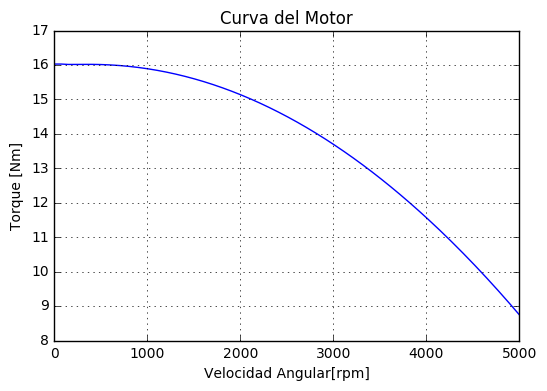

In [14]:
om=np.linspace(1,5000,num=200)
torq=[None]*len(om)

for idx,ang in enumerate(om):
    torq[idx]=torque_motor(ang)
plt.plot(om,torq)
plt.xlabel('Velocidad Angular[rpm]')
plt.ylabel('Torque [Nm]')
plt.title('Curva del Motor')
plt.grid()
plt.show()

La anterior grafica muestra una curva de motro como se espera donde inicialmente el torque es constante y luego este decrece a medida que aumenta la velocidad angular. 

|Ecuacion a resolver

In [15]:
def dveldt(velv,t0,mass=masa,area=af,N=ng,ref=refc):
    xx,vel=velv
     
    omega_motor=velx_a_omegaMotor(vel,N)
    frod=frodarura_const(vel,mass)
    farr=farrastre(vel,area)
    fin=finclinacion(theta,mass)
    Tmot=torque_motor(omega_motor)
    masa_eq=eq_mass(mass)
    acel=(Tmot*N*etaf/ref - frod - farr-fin)/masa_eq
    
    velmax=velmot_a_velkart(omega_max,N,ref)
    if vel>=velmax:
        acel=0
        vel=velmax
       # print(t0) # Impresion para ver a que segundo se llega a la velocidad 
    #maxima
    return [vel,acel]



Variables del tiempo

In [16]:
t_in=0.0;
t_fin=120
deltat=0.00001
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)


Solucion

In [17]:
#ar=(100,2,2,0.3) Cambiar argumentos de entrada
sol=odeint(dveldt,c_ini,t)
#La velocidad maxima se llega al segund t0=18.7
ace=np.gradient(sol[:,1])/deltat


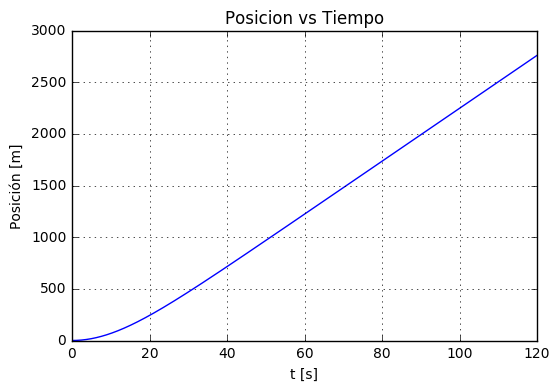

In [18]:
plt.plot(t,sol[:,0],label='posicion(t)')
plt.ylabel('Posición [m]')
plt.xlabel('t [s]')
plt.title('Posicion vs Tiempo')
plt.grid()
plt.show()

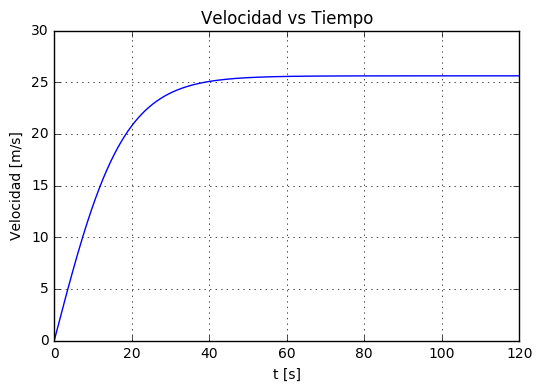

In [19]:

plt.plot(t,sol[:,1],label='velocidad(t)')
plt.ylabel('Velocidad [m/s]')
plt.xlabel('t [s]')
plt.title("Velocidad vs Tiempo")
plt.grid()
plt.show()

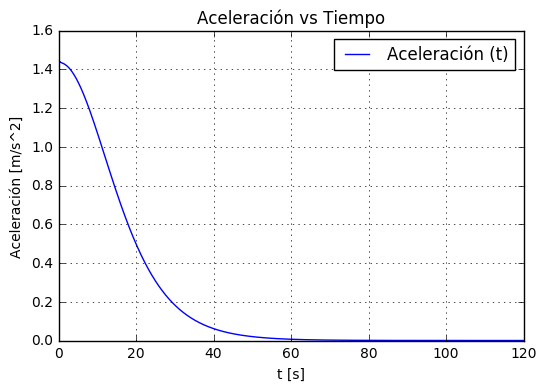

In [20]:
plt.plot(t,ace,label="Aceleración (t)")
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('Aceleración [m/s^2]')
plt.title('Aceleración vs Tiempo')
plt.grid()
plt.show()

A continuacion se hara una funcion para encontrar la velocidad maxima. Inentando evitar la necesidad de poner un tiemo excesivamente largo

In [21]:
def find_maxvel(t_0,t_end,deltat,c_ini,mass=masa,area=af,N=ng,ref=refc):
    t=np.arange(t_0,t_end,deltat)
    
    ar=(mass,area,N,ref)
    sol=odeint(dveldt,c_ini,t,ar)
    
    tol=0.05*deltat #[m/s2]
    
    if (tol>(abs(sol[-1,1]-sol[-2,1]))):
        
        ind=np.argmax(sol[1:,1]-sol[:-1,1]<tol)
        if ind==0:
            ind=-1
        velmax=sol[ind,1]
        tmax=t[ind]
    else: 
        t_1=t[-1]
        t_end2=t_1+10
        (tmax,velmax)=find_maxvel(t_1,t_end2,deltat,sol[-1,:],mass,area,N,ref)
    return tmax,velmax
 
    
    

In [22]:
#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=10
deltat=0.0001
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

In [23]:
t_vmax,vmax=find_maxvel(t_in,t_fin,deltat,c_ini)
print("Bajo las condiciones actuales se llega a la velocidad maxima de %.2f m/s en un tiempo de %.2fs" %(vmax,t_vmax))

Bajo las condiciones actuales se llega a la velocidad maxima de 25.17 m/s en un tiempo de 41.82s


Comparando el resultado de la grafica anterior de la velocidad vs el tiempo es posible decir que esta función si logra su cometido. Ya que el tiempo de estabilizacion de la grafica concuerda con este resultado

A continuación se ve el uso que tiene esta función para graficar unicamente la aceleracíon mas 1 segundo para que se vea que se ha llegado a la velocidad maxima

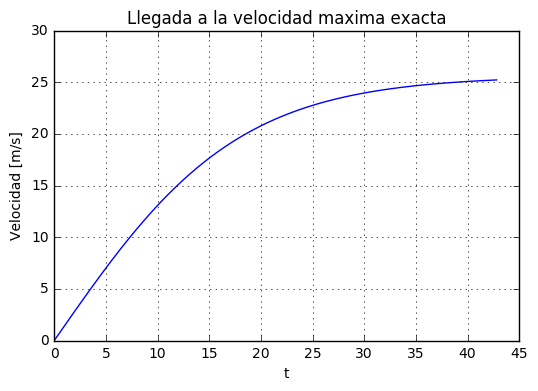

In [24]:
#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=t_vmax+1
deltat=0.0001
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)


sol=odeint(dveldt,c_ini,t)

#plot del sistema
plt.plot(t,sol[:,1],label='velocidad(t)')
plt.ylabel('Velocidad [m/s]')
plt.xlabel('t')
plt.title("Llegada a la velocidad maxima exacta")
plt.grid()
plt.show()

# Funciones Frenado

In [25]:
torqueFreno=-25
#Freno delantero
def fbf(vx,Tf,N,ref):
    return Tf*N*etaf/ref #[N]
#Freno trasero
def fbr(vx,Tf,N,ref):
    return Tf*N*etaf/ref #[N]

In [26]:
def dvfrendt(velv,t0,mass=masa,area=af,N=ng,ref=refc,Tf=torqueFreno):
   xx,vel=velv
     
   omega_motor=velx_a_omegaMotor(vel,N)
   frod=frodarura_const(vel,mass)
   farr=farrastre(vel,area)
   fin=finclinacion(theta,mass)
   masa_eq=eq_mass(mass)

   frenD=fbf(vel,Tf,N,ref)
   frenT=fbr(vel,Tf,N,ref)
   
   acel=(frenD+frenT - frod - farr-fin)/masa_eq
   if vel<0:
    acel=0
    vel=0
    
   
   return [vel,acel] 

Condiciones iniciales prueba frenado

In [27]:
t_in=0.0;
t_fin=40.0
deltat=0.001
#condiciones iniciales
x_0=0
v_0=28
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

Solucion prueba frenado

In [28]:
sol=odeint(dvfrendt,c_ini,t)
ace=np.gradient(sol[:,1])/deltat
ace

array([-5.85603473, -5.85582627, -5.85540939, ...,  0.        ,
        0.        ,  0.        ])

Grafica frenado

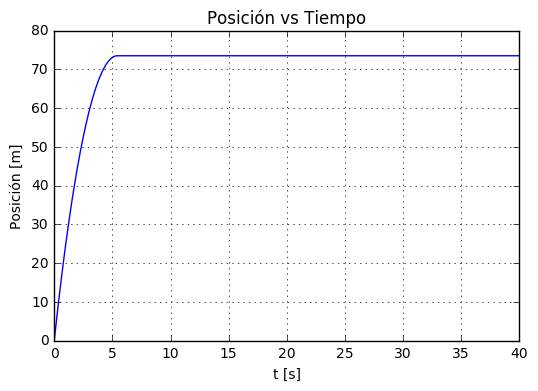

In [29]:
plt.plot(t,sol[:,0],label='posicion(t)')
plt.ylabel('Posición [m]')
plt.title('Posición vs Tiempo')
plt.xlabel('t [s]')
plt.grid()
plt.show()

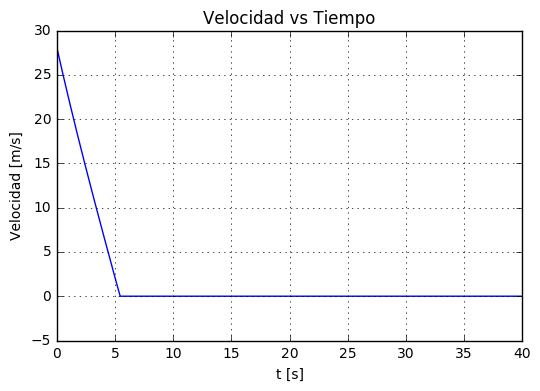

In [30]:
plt.plot(t,sol[:,1],label='velocidad(t)')
plt.ylabel('Velocidad [m/s]')
plt.xlabel('t [s]')
plt.title('Velocidad vs Tiempo')
plt.grid()
plt.show()

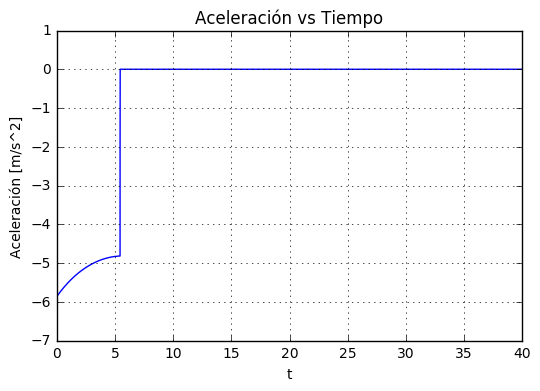

In [31]:
plt.plot(t,ace,label="Aceleración (t)")
plt.ylabel("Aceleración [m/s^2]")
plt.xlabel('t')
plt.title("Aceleración vs Tiempo")
plt.grid()
plt.ylim((-7,1))
plt.show()

De misma manera que se  genero una funcion que encontraba el tiempo de velocidad maxima la siguiente funcion encuentra el tiempo de freno según alguna velocidad inicial 

In [32]:
def find_tiempofreno(t_0,t_end,deltat,c_ini,mass=masa,area=af,N=ng,ref=refc,Tf=torqueFreno):
    t=np.arange(t_0,t_end,deltat)
    
    ar=(mass,area,N,ref,Tf)
    sol=odeint(dvfrendt,c_ini,t,ar)
    
    
    
    if (0>=sol[-1,1]):
        
        ind=np.argmax(sol[:,1]<=0)
        if ind==0:
            ind=-1
        tmax=t[ind]
    else: 
        t_1=t[-1]
        t_end2=t_1+10
        tmax=find_tiempofreno(t_1,t_end2,deltat,sol[-1,:],mass,area,N,ref,Tf)
    return tmax
 

In [33]:
#condiciones iniciales
t_in=0.0;
t_fin=20
deltat=0.0001
#condiciones iniciales
x_0=0
v_0=28
c_ini=[x_0,v_0]


In [34]:
t_fren=find_tiempofreno(t_in,t_fin,deltat,c_ini)
print("El tiempo de frenado es %.2f"%t_fren)

El tiempo de frenado es 5.43


El tiempo de frenado anteriormente tambien concuerda con las graficas de frenado. 

# Prueba de aceleración y desaceleracion 

In [35]:
def acel_desacel(velv,t0,mass=masa,area=af,N=ng,ref=refc,Tf=torqueFreno,Tfreno=20):
    if t0<=Tfreno:
        acelv=dveldt(velv,t0,mass=masa,area=af,N=ng,ref=refc)
    else:
        acelv=dvfrendt(velv,t0,mass=masa,area=af,N=ng,ref=refc,Tf=torqueFreno)
    return acelv


Condiciones iniciales

In [36]:
#condiciones iniciales
x_0=0
v_0=0
c_ini=[x_0,v_0]
#Requiera mayor resolucion 
deltat=0.000003
t_in=0.0;
t_freno,vmax=find_maxvel(0,10,deltat,c_ini,mass=masa,area=af,N=ng,ref=refc)
t_freno=t_freno+2
t_fin=t_freno+ find_tiempofreno(0,10,deltat,[0,vmax],mass=masa,area=af,N=ng,ref=refc,Tf=torqueFreno)+2


t=np.arange(t_in,t_fin,deltat)
ar=(masa,af,ng,refc,torqueFreno,t_freno)

Solucion con un ODE

In [37]:
sol=odeint(acel_desacel,c_ini,t,ar)
ace=np.gradient(sol[:,1])/deltat

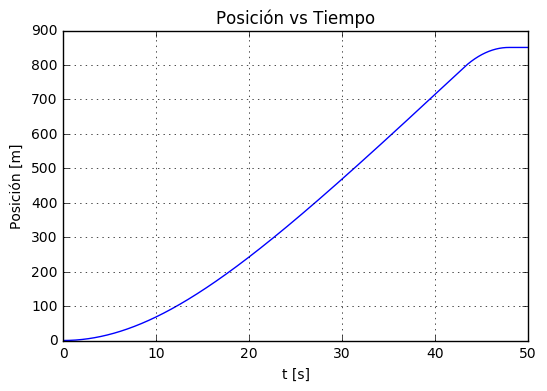

In [38]:
plt.plot(t,sol[:,0],label='posicion(t)')
plt.xlabel('t [s]')
plt.ylabel('Posición [m]')
plt.title('Posición vs Tiempo')
plt.grid()
plt.show()

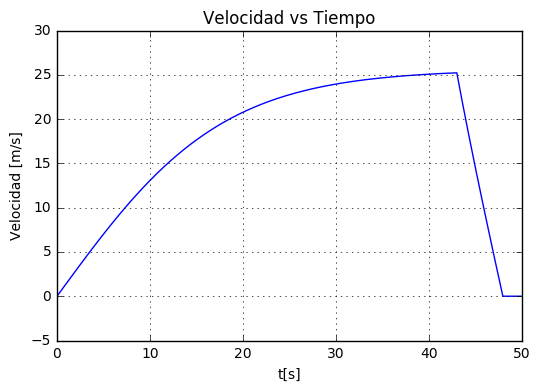

In [39]:
plt.plot(t,sol[:,1],label='velocidad(t)')
plt.xlabel('t[s]')
plt.ylabel('Velocidad [m/s]')
plt.title('Velocidad vs Tiempo')
plt.grid()
plt.show()

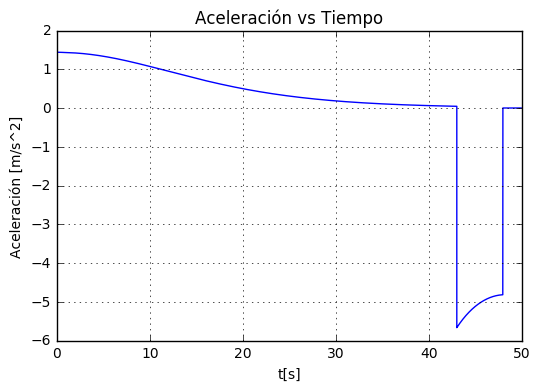

In [40]:
plt.plot(t,ace,label="Aceleración (t)")
plt.ylabel('Aceleración [m/s^2]')
plt.xlabel('t[s]')
plt.title('Aceleración vs Tiempo')
plt.grid()
plt.show()

Estas tres graficas muestran que primero el freno es mucho mas fuerte que la aceleracion de los motores. Puesto que llegan a una aceleracion de 5 m/s^2 por otro lado a estas vlelocidades y con esto valores la fuerza de arrastre y las fuerzas de rodaduras no son los limitantes para la velocidad del carro. Estas son las condiciones del kart actual en el cual llega a la velocidad maxima y rapidamente llega a 0 esto se demora aproximadamente 31 segundos en total.  

# Comprobacion de importancia de cada uno de las variables
Las variables a revisar son: la Masa, la relacion de la cadena , el radio efectivo de las llantas y el area efectivo del kart
Para cada variable se observara la velocidad maxima, el tiempo de velocidad maxima, tiempo para recorrer 100, 500, y 1000 metros

## Masa

In [41]:
masas=np.arange(80,260,10)
v_m=[None]*len(masas)
t_m=[None]*len(masas)
cien_m=[None]*len(masas)
quin_m=[None]*len(masas)
kilomet=[None]*len(masas)

#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=10
deltat=0.005
dt=[0.0005,0.001,0.001,0.001,0.001,0.001,0.001,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

for idx,ma in enumerate(masas):
    t_m[idx],v_m[idx]=find_maxvel(t_in,t_fin,dt[idx],c_ini,masas[idx],af,ng,refc) 

 

t_in=0.0;
t_fin=100
deltat=0.005
dt=[0.0005,0.001,0.005,0.001,0.001,0.001,0.001,0.001,0.005,0.001,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=17
for idx,ma in enumerate(masas):
    ar=(masas[idx],af,ng,refc)
    t=np.arange(t_in,t_fin,dt[idx])
    sol=odeint(dveldt,c_ini,t,ar)
    cien_m[idx]=t[np.argmax(sol[:,0]>100)]
    quin_m[idx]=t[np.argmax(sol[:,0]>500)]
    kilomet[idx]=t[np.argmax(sol[:,0]>1000)]


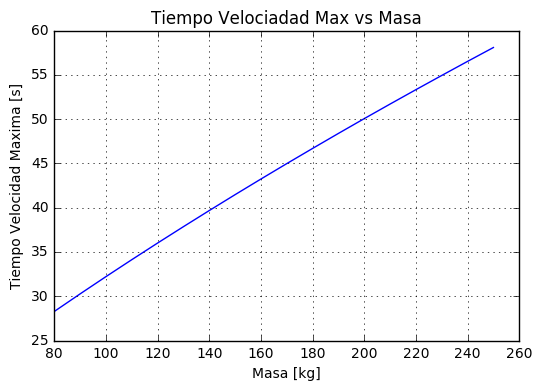

In [42]:
plt.plot(masas,t_m)
plt.xlabel('Masa [kg]')
plt.ylabel('Tiempo Velocidad Maxima [s]')
plt.title('Tiempo Velociadad Max vs Masa')
plt.grid()
plt.show()

Esta grafica muestra que la masa hace que el tiempo para llegar a la velocidad maxima aumente. Segun esto es deseable tener un kart liviano (Obviamente). La relacion entre masa y tiempo de velocidad maxima es lineal

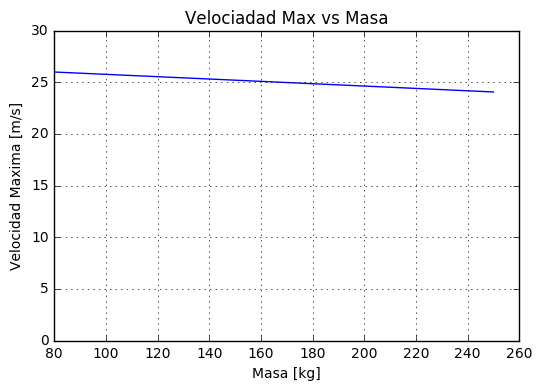

In [43]:
plt.plot(masas,v_m)
plt.xlabel('Masa [kg]')
plt.ylabel('Velocidad Maxima [m/s]')
plt.title('Velociadad Max vs Masa')
plt.ylim((0,30))
plt.grid()
plt.show()

Esta grafica muestra que bajo las condiciones actuales la masa no afecta la velocidad maxima del kart. Si esta conclusion se une con la anterior. Para tener un kart mas rapido es necesario tener un kart liviano

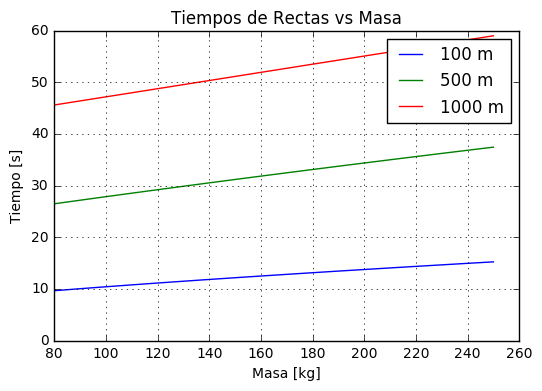

In [44]:
plt.plot(masas,cien_m,label='100 m')
plt.plot(masas,quin_m,label='500 m')
plt.plot(masas,kilomet,label='1000 m')
plt.xlabel('Masa [kg]')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de Rectas vs Masa')
plt.grid()
plt.legend(loc='best')
plt.show()

Por ultimo esta grafica muestra el efecto que tiene la masa en diferentes carreras. Se muestra el mismo patron en cada uno de los casos mostrados. Por ende si se buscan mejorar los tiempos es importante mantener el peso lo minimo posible

## Relacion Cadena


In [45]:
relaciones=np.linspace(0.2,5,15)
v_m=[None]*len(relaciones)
t_m=[None]*len(relaciones)
cien_m=[None]*len(relaciones)
quin_m=[None]*len(relaciones)
kilomet=[None]*len(relaciones)

#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=10
deltat=0.005
dt=[0.0005,0.001,0.001,0.001,0.001,0.001,0.001,0.005,0.005,0.005,0.005,0.005,0.001,0.005,0.001,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=12
for idx,cad in enumerate(relaciones):
    t_m[idx],v_m[idx]=find_maxvel(t_in,t_fin,dt[idx],c_ini,masa,af,relaciones[idx],refc) 

 

t_in=0.0;
t_fin=1000
deltat=0.005
dt=[0.0005,0.001,0.005,0.001,0.001,0.001,0.001,0.001,0.005,0.001,0.005,0.005,0.005,0.005,0.001,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=14
for idx,cad in enumerate(relaciones):
    ar=(masa,af,relaciones[idx],refc)
    t=np.arange(t_in,t_fin,dt[idx])
    sol=odeint(dveldt,c_ini,t,ar)
    cien_m[idx]=t[np.argmax(sol[:,0]>100)]
    quin_m[idx]=t[np.argmax(sol[:,0]>500)]
    kilomet[idx]=t[np.argmax(sol[:,0]>2000)]



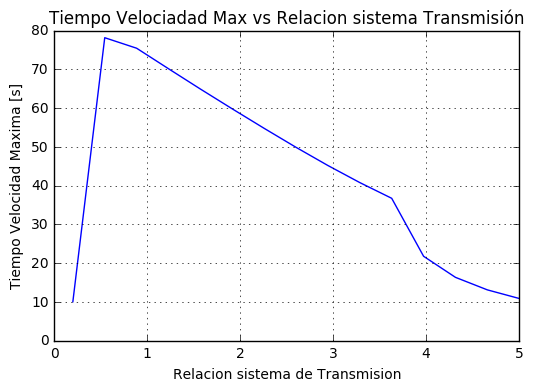

In [46]:
plt.plot(relaciones,t_m)
plt.xlabel('Relacion sistema de Transmision')
plt.ylabel('Tiempo Velocidad Maxima [s]')
plt.title('Tiempo Velociadad Max vs Relacion sistema Transmisión')
plt.grid()
plt.show()

La presente grafica muestra que a mayor relacion de la cadena más rapido se llega la velocidad máxima. Sola esta grafica no nos dice mucho. Puesto que no habla de cual es la velocidad máxima

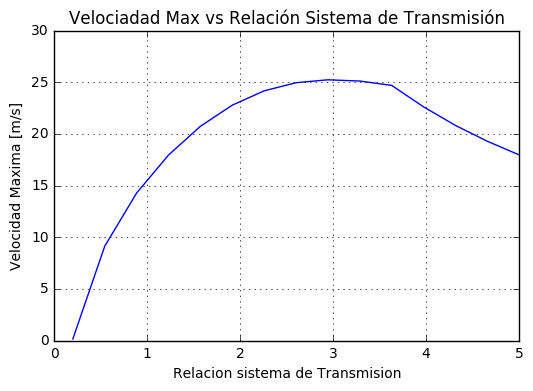

In [47]:
plt.plot(relaciones,v_m)
plt.xlabel('Relacion sistema de Transmision')
plt.ylabel('Velocidad Maxima [m/s]')
plt.title('Velociadad Max vs Relación Sistema de Transmisión')
plt.grid()
plt.show()

En esta gráfica se puede concluir que la máxima velocidad ocurre cuando la relación de transmisión de potencia es cercana a 3. Esto muestra que la relación que se tiene actualmente es ideal en cierto modo. No obstante es importante entender que la velocidad de la vuelta depende de la velocidad máxima del kart y el tiempo en que se demora en llegar a esta velocidad puesto que no sirve de nada tener una velocidad alta si no hay espacio suficiente para alcanzar la. Puede ser más deseable lograr llegar a un velocidad máxima más pequeña pero de una forma más rapida.

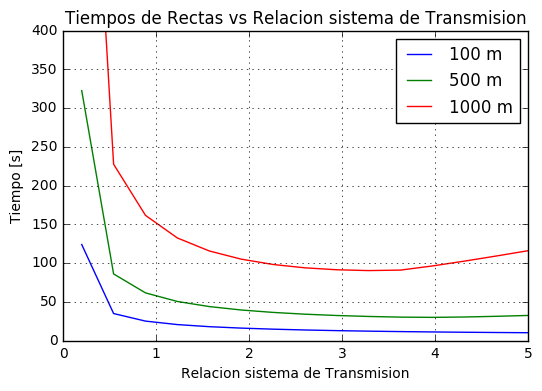

In [48]:
plt.plot(relaciones,cien_m,label='100 m')
plt.plot(relaciones,quin_m,label='500 m')
plt.plot(relaciones,kilomet,label='1000 m')
plt.xlabel('Relacion sistema de Transmision')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de Rectas vs Relacion sistema de Transmision')
plt.grid()
plt.legend(loc='best')
plt.ylim((0,400))
plt.show()

Esta gráfica ayuda a enter mucho lo anterior. Primero se observa que definitivamente a bajas relaciones este el tiempo de kart en una carrera no sirve de nada, puesto que los tiempos son demasiado largos. Por otro lado parece que el menor tiempo de cada distancia esta cuando la relacion de transmision es cercano a 3 lo cual afirma lo dicho anteriormente y que las decisiones de diseño que se han tomado son las correctas. Es importante notar que esta relación de transmision es la ideal para todas las distancias. 

## Area Frontal


In [49]:
af

0.429

In [50]:
#af original =0.429 m^2
areaf=np.linspace(0.2,1,15)
v_m=[None]*len(areaf)
t_m=[None]*len(areaf)
cien_m=[None]*len(areaf)
quin_m=[None]*len(areaf)
kilomet=[None]*len(areaf)

#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=100
deltat=0.005
dt=[0.0005,0.001,0.001,0.001,0.001,0.001,0.001,0.005,0.005,0.005,0.005,0.005,0.001,0.005,0.001,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=12
for idx,cad in enumerate(relaciones):
    t_m[idx],v_m[idx]=find_maxvel(t_in,t_fin,dt[idx],c_ini,masa,areaf[idx],ng,refc) 



t_in=0.0;
t_fin=1500
deltat=0.005
dt=[0.0005,0.001,0.005,0.001,0.001,0.001,0.001,0.001,0.005,0.001,0.005,0.005,0.005,0.005,0.001,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=14
for idx,cad in enumerate(relaciones):
    ar=(masa,areaf[idx],ng,refc)
    t=np.arange(t_in,t_fin,dt[idx])
    sol=odeint(dveldt,c_ini,t,ar)
    cien_m[idx]=t[np.argmax(sol[:,0]>100)]
    quin_m[idx]=t[np.argmax(sol[:,0]>500)]
    kilomet[idx]=t[np.argmax(sol[:,0]>2000)]



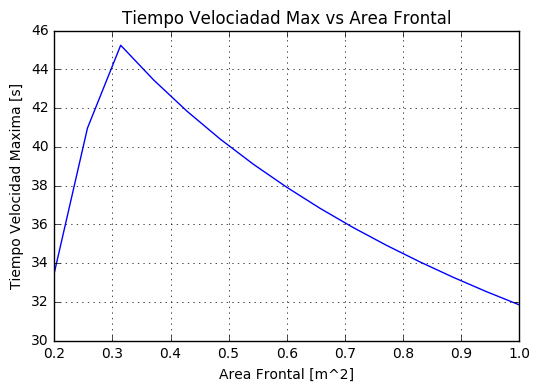

In [51]:
plt.plot(areaf,t_m)
plt.xlabel('Area Frontal [m^2]')
plt.ylabel('Tiempo Velocidad Maxima [s]')
plt.title('Tiempo Velociadad Max vs Area Frontal')
plt.grid()
plt.show()

Esta grafica muesta que hay un pico en el cual uno se demora más llegando a la velocidad maxima. A ambos lados de esta el tiempo cae rapidamente. Esto puede llevar hacer que uno piense que se debe evitar tener un area frontal entre 0.23 y 0.5. Otra explicacion es porque en el punto máximo es posible llega a cierta velocidad maxima y por eso se demora en llegar a esta. La otras graficas seran de gran ayuda para resolver esto. 

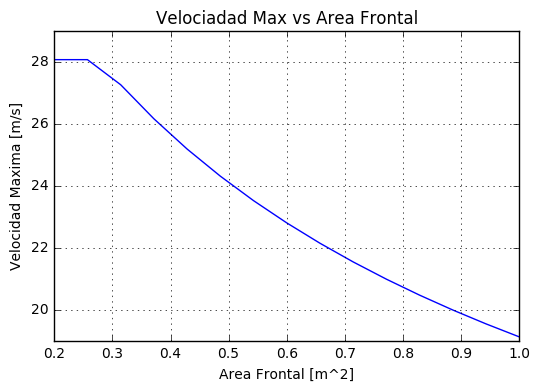

In [52]:
plt.plot(areaf,v_m)
plt.xlabel('Area Frontal [m^2]')
plt.ylabel('Velocidad Maxima [m/s]')
plt.title('Velociadad Max vs Area Frontal')
plt.grid()
plt.show()

En esta grafica se observa que a menor area frontal mayor la velocidad maxima que puede alcanzar el kart. Desde 0.2 a 0.26 se puede ver que la velocidad es maxima y es exactamente igual a la velocidad maxima calculada. Por otro lado, la grafica empieza con un parte plana y luego empieza a decaer. Dentro de este periodo plano la velocidad maxima del motor es el factor limitante mientras que despues de esto, la fuerza de arrastre que disminuye la velocidad maxima del kart.  Esto dice que a menor area frontal más rapido será el kart. No obstante si el area es menor a 0.26 el area frontal no importa

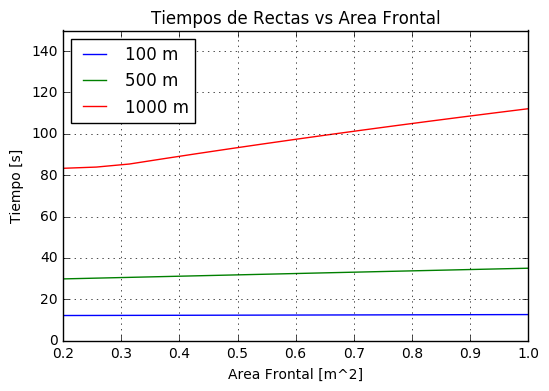

In [53]:
plt.plot(areaf,cien_m,label='100 m')
plt.plot(areaf,quin_m,label='500 m')
plt.plot(areaf,kilomet,label='1000 m')
plt.xlabel('Area Frontal [m^2]')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de Rectas vs Area Frontal')
plt.grid()
plt.legend(loc='best')
plt.ylim((0,150))
plt.show()

Por ultimo, la grafica en la parte superior muestra que en pequeñas distancia el area frontal permite ahorar unos segundos en el tiempo de la carrera. Esto es aun más cierto para distancia grandes . En las cuales se suman más de 30 segundos al tiempo de recorrido como se observa en la serie de 1000 m. Este no tiene un efecto tan evidente como los otro variables pero es un factor importante y controlable dentro del diseño del kart. Es este factor que permite ganar o perder carreras por milesimas de segundos. 


## Radio efectivo de las llantas

In [54]:
# El radio efectivo actual es de : 0.171499


refe=np.linspace(0.1,0.4,20)
v_m=[None]*len(refe)
t_m=[None]*len(refe)
cien_m=[None]*len(refe)
quin_m=[None]*len(refe)
kilomet=[None]*len(refe)

#Condiciones iniciales y condiciones de tiempo
t_in=0.0;
t_fin=100
deltat=0.005
dt=[0.0005,0.001,0.001,0.001,0.001,0.001,0.001,0.005,0.005,0.005,0.005,0.005,0.001,0.005,0.001,0.005,0.005,0.005,0.005,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=12
for idx,rllantas in enumerate(refe):
    t_m[idx],v_m[idx]=find_maxvel(t_in,t_fin,dt[idx],c_ini,masa,af,ng,refe[idx]) 



t_in=0.0;
t_fin=1500
deltat=0.005
dt=[0.0005,0.001,0.005,0.001,0.001,0.001,0.001,0.001,0.005,0.001,0.005,0.005,0.005,0.005,0.001,0.005,0.005,0.005,0.005,0.005]
#condiciones iniciales
x_0=0.0
v_0=0.0
c_ini=[x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

#idx=14
for idx,rllantas in enumerate(refe):
    ar=(masa,af,ng,refe[idx])
    t=np.arange(t_in,t_fin,dt[idx])
    sol=odeint(dveldt,c_ini,t,ar)
    cien_m[idx]=t[np.argmax(sol[:,0]>100)]
    quin_m[idx]=t[np.argmax(sol[:,0]>500)]
    kilomet[idx]=t[np.argmax(sol[:,0]>2000)]



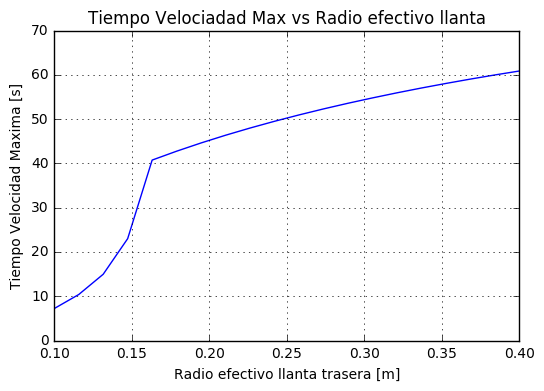

In [55]:
plt.plot(refe,t_m)
plt.xlabel('Radio efectivo llanta trasera [m]')
plt.ylabel('Tiempo Velocidad Maxima [s]')
plt.title('Tiempo Velociadad Max vs Radio efectivo llanta')
plt.grid()
plt.show()

Esta grafica dice que a menor radio de llantas más rapido se llegar a la velocidad máxima. Ya despues de 0.16 m el crecimiento del tiempo a la velocidad máxima disminuye. Y nos dice que en terminos de velocidad para llegar a la velocidad máxima es preferible mantener el tamaño de la llanta efectivo bajo. 

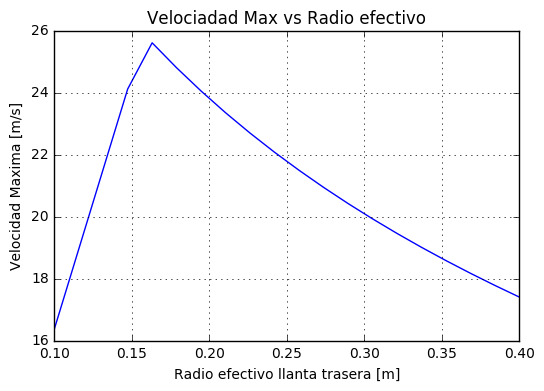

In [56]:
plt.plot(refe,v_m)
plt.xlabel('Radio efectivo llanta trasera [m]')
plt.ylabel('Velocidad Maxima [m/s]')
plt.title('Velociadad Max vs Radio efectivo')
plt.grid()
plt.show()

Esta grafica muestra el comportamiento de la velocidad maxima segun el redio efectivo. En este caso es posible observar que hay un tamaño de llanta optimo. Este punto esta cercano a 0.16m. Este punto esta dividido por este punto. Es posible hacer la hipotesis que antes de este punto es posible que la velocidad se limita por la velocidad máxima del motor. Mientras que despues el punto optimo la velocidad es limitada casi que exclusivamente por las fuerzas aerodinamicas. Dentro de este analisis caba mencionar que para este experimento, en el cambio de diametro se tuvo en cuenta unicamente el cambio de radio no el cambio de masa ni de incercia. 

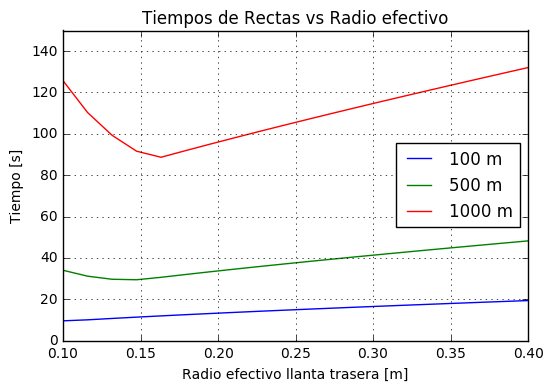

In [57]:
plt.plot(refe,cien_m,label='100 m')
plt.plot(refe,quin_m,label='500 m')
plt.plot(refe,kilomet,label='1000 m')
plt.xlabel('Radio efectivo llanta trasera [m]')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de Rectas vs Radio efectivo')
plt.grid()
plt.legend(loc='best')
plt.ylim((0,150))
plt.show()

En esta Grafica se observa como a distancias pequeñas es mejor tener un radio de llanta pequeño. Mientras que ya a 500 metros o a 1000 m el mejor punto existe como un minimo. En los 500 m el minimo esta al rededor de 0.14 m y en los 1000 metros el minimo es a a 0.18 metros. Esto es un dato interestante por que dice que la llanta optima depende de la logitud de las rectas que se va a correr. Es posible que el diseño optimo de estos dependa de la forma de la pista. Por otro lado parece que este minimo a medida que se alarga la recta tiende a 0.16.